In [152]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [153]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [154]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [155]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([df_test,df_train],ignore_index=True) # объединяем

In [156]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Смотрим на столбцы, определаем план работы с признакими:
* 0 адрес отеля : отсюда можно взять признак страна и город отеля (очень похожи)
* 1 additional_number_of_scoring - так оставить (хоть есть корреляция)
* 2 review_date                                 признак год, месяц, день??? 
* 3   average_score                               оценка наиболее значимый признак должен быть (похож с таргет)
* 4   hotel_name                                 имя в итоге ничего не даст, количество уникальных значений...(повторы?
* 5   reviewer_nationality                        кодировать в бинарные (их очень много)
* 6   negative_review                            сделать функцию частые слова - новые признаки*(1)*
* 7   review_total_negative_word_counts          ничего не меняем (должен быть хороший признак
* 8   total_number_of_reviews                     корреляция с дополнительным, оставляем пока
* 9   positive_review                             кодируем 10 по частоте слов? *(1)*
* 10  review_total_positive_word_counts            ничего не меняем
* 11  total_number_of_reviews_reviewer_has_given  оставляем
* 12  reviewer_score                              таргет
* 13  tags                                        дополнительно несколько признако (по частоте) , призак количество ночей
* 14  days_since_review                           меняем признак на количественный (не кажется, что влияет на оценку), не очень понятный признак
* 15  lat                                        надо заполнить пропуски
* 16  lng                                       надо заполнить пропуски

In [157]:
#проверим дубликаты
hotels_dubl = hotels[hotels.duplicated()]
hotels_dubl['hotel_name']

26726     Copthorne Tara Hotel London Kensington
49098                H tel Concorde Montparnasse
49541                H tel Concorde Montparnasse
50267                                H tel Baume
51878                H tel Concorde Montparnasse
                           ...                  
512039                               H tel Baume
512118               H tel Concorde Montparnasse
512733               H tel Concorde Montparnasse
513053               H tel Concorde Montparnasse
514376               H tel Concorde Montparnasse
Name: hotel_name, Length: 336, dtype: object

In [158]:
# возьмем пример конкретного отеля из списка дубликатов
hotels_dubl[hotels_dubl['hotel_name'] == hotels_dubl['hotel_name'][49098]]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
49098,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,7/16/2017,7.9,H tel Concorde Montparnasse,United States of America,No Negative,0,2515,Good location for late night arrival by train...,29,2,"[' Leisure trip ', ' Family with young childre...",18 days,48.838108,2.318669,0,0.0
49541,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,4/9/2017,7.9,H tel Concorde Montparnasse,Lebanon,Elevator needs restoration Cleaning,5,2515,No Positive,0,12,"[' Leisure trip ', ' Solo traveler ', ' Classi...",116 day,48.838108,2.318669,0,0.0
51878,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,7/5/2017,7.9,H tel Concorde Montparnasse,Belgium,Absence of a proper fridge what they call min...,25,2515,Very comfy beds friendly and efficient recept...,9,9,"[' Leisure trip ', ' Solo traveler ', ' Classi...",29 days,48.838108,2.318669,0,0.0
53975,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,12/24/2015,7.9,H tel Concorde Montparnasse,France,No Negative,0,2515,Good location for station and buses to CDG Ai...,11,32,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",588 day,48.838108,2.318669,0,0.0
81775,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,6/14/2017,7.9,H tel Concorde Montparnasse,Australia,No Negative,0,2515,Location,2,16,"[' Leisure trip ', ' Group ', ' Deluxe Double ...",50 days,48.838108,2.318669,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511651,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,9/22/2015,7.9,H tel Concorde Montparnasse,Lebanon,The wifi is horrible Always something is need...,41,2515,The location is half an hour walking to saint...,16,3,"[' Leisure trip ', ' Couple ', ' Deluxe Double...",681 day,48.838108,2.318669,1,7.5
512118,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,7/28/2016,7.9,H tel Concorde Montparnasse,France,A bit noisy old fashion At almost 20 the brea...,18,2515,Convenient if one arrives departs from the Mo...,10,48,"[' Business trip ', ' Solo traveler ', ' Class...",371 day,48.838108,2.318669,1,6.7
512733,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,5/15/2017,7.9,H tel Concorde Montparnasse,United Kingdom,twice spoken to staff to replace the coffee w...,24,2515,Tea making facilities not in the room only co...,11,2,"[' Leisure trip ', ' Couple ', ' Superior Doub...",80 days,48.838108,2.318669,1,7.9
513053,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,10/12/2015,7.9,H tel Concorde Montparnasse,Australia,No great restaurants within a short walk but ...,12,2515,The Hotel was wonderfully p laced for us to a...,44,24,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",661 day,48.838108,2.318669,1,10.0


видим, что записи не полностью идентичны, поэтому не будем удалить дубиликаты, тем более их всего 336 

убиерем пропуски, они есть в стобцах 'lat'и 'lng': 

In [159]:
# создадим список с пропущеными значениям
hotels_isnull = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]
list_null = hotels_isnull['hotel_name'].value_counts()
list_isnull = set(hotels_isnull['hotel_name'])
display(list_isnull)
print('количество отелей с пустыми координатами:', len(list_isnull))
list_isnull = list(list_isnull)

{'Austria Trend Hotel Schloss Wilhelminenberg Wien',
 'City Hotel Deutschmeister',
 'Cordial Theaterhotel Wien',
 'Derag Livinghotel Kaiser Franz Joseph Vienna',
 'Fleming s Selection Hotel Wien City',
 'Holiday Inn Paris Montmartre',
 'Hotel Advance',
 'Hotel Atlanta',
 'Hotel City Central',
 'Hotel Daniel Vienna',
 'Hotel Park Villa',
 'Hotel Pension Baron am Schottentor',
 'Maison Albar Hotel Paris Op ra Diamond',
 'Mercure Paris Gare Montparnasse',
 'NH Collection Barcelona Podium',
 'Renaissance Barcelona Hotel',
 'Roomz Vienna'}

количество отелей с пустыми координатами: 17


In [160]:
# заполним пропуски с помощью библиотеки geopy
! pip install geopy

In [161]:
from geopy import GoogleV3
from geopy.geocoders import Nominatim #Подключаем библиотеку
geolocator = Nominatim(user_agent="Tester") #Указываем название приложения (так нужно, да)
c = 0
lst_emp = list()
list_isnull_new = list_isnull.copy()
dict_lat = {}# словарь с широтой
dict_lng = {}# словарь с долготой

for i in list_isnull:

    location = geolocator.geocode(i)
    if location is not None:
     # заполняем все пропуски в координатах
        dict_lat[i] = location.latitude
        dict_lng[i] = location.longitude
        # создадим список отелей без координат
        list_isnull_new == list_isnull_new.remove(i)
    else:
        c = c + 1
        
print('не смог определить координаты у {} отелей'.format(c))    
print(list_isnull_new)

не смог определить координаты у 6 отелей
['Maison Albar Hotel Paris Op ra Diamond', 'City Hotel Deutschmeister', 'Derag Livinghotel Kaiser Franz Joseph Vienna', 'Hotel Pension Baron am Schottentor', 'Mercure Paris Gare Montparnasse', 'Fleming s Selection Hotel Wien City']


In [162]:
#Для тех отелей, где еще остались пропуск, заполним координаты в ручную
dict_lat['Mercure Paris Gare Montparnasse'] = 48.8375841
dict_lng['Mercure Paris Gare Montparnasse'] = 2.318716
dict_lat['Derag Livinghotel Kaiser Franz Joseph Vienna'] = 48.24602040535342
dict_lng['Derag Livinghotel Kaiser Franz Joseph Vienna'] = 16.341979665380066
dict_lat['City Hotel Deutschmeister'] = 48.220959067776576
dict_lng['City Hotel Deutschmeister'] = 16.366654496291574
dict_lat['Fleming s Selection Hotel Wien City'] = 48.209464156084664
dict_lng['Fleming s Selection Hotel Wien City'] = 16.353436330884335
dict_lat['Hotel Pension Baron am Schottentor'] = 48.2169642294284
dict_lng['Hotel Pension Baron am Schottentor'] = 16.36044753578845
dict_lat['Maison Albar Hotel Paris Op ra Diamond'] = 48.87539377471044
dict_lng['Maison Albar Hotel Paris Op ra Diamond'] = 2.323428222173738

In [163]:
# Теперь из словаря заполняем координаты
for i in range(len(hotels['lat'])):

    if pd.isnull(hotels['lat'][i]) is True:
        hotels['lat'][i] = dict_lat[hotels['hotel_name'][i]]
        hotels['lng'][i] = dict_lng[hotels['hotel_name'][i]] 

/tmp/ipykernel_32/3870895649.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels['lat'][i] = dict_lat[hotels['hotel_name'][i]]
/tmp/ipykernel_32/3870895649.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels['lng'][i] = dict_lng[hotels['hotel_name'][i]]


In [164]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Как видим, пропусков не осталось

**hotel_address**

In [165]:
# Выведем несколько значений адреса отеля
print(hotels['hotel_address'][5])
print(hotels['hotel_address'][15])
print(hotels['hotel_address'][25])

Coram Street Camden London WC1N 1HT United Kingdom
Oudeschans 75 Amsterdam City Center 1011 KW Amsterdam Netherlands
3 Rue Verniquet 17th arr 75017 Paris France


Видим, что из адерса можно определить страну и город отеля, создадим новые признак

In [166]:
# создаем признак страна отеля
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-1])

In [167]:
hotels['hotel_country'].value_counts()

Kingdom        262301
Spain           60149
France          59928
Netherlands     57214
Austria         38939
Italy           37207
Name: hotel_country, dtype: int64

In [168]:
# создаем признак город отеля (для великобритании город будем -5, остальные -2)
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-5] if x.split(' ')[-1] == 'Kingdom' else x.split(' ')[-2])

In [23]:
hotels['hotel_city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

из новых признаков видим, что одна страна = один город, так что скорее признаки дублируют друг друга (будет корреляция 1), но если появится новый город, то признак будет полезен

In [169]:
# кодируем признаки  
hotels = pd.get_dummies(hotels, columns=['hotel_country', 'hotel_city'])
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

**reviewer_nationality**

In [170]:
hotels['reviewer_nationality'].value_counts()

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

In [171]:
#кодируем признак национальность, так как их много, то испльзуем BinaryEncoder
import category_encoders as ce

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [172]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

**review_date**

In [174]:
# работаем с датой отзыва
# Переведем в тип дата и создадим новые признаки (день и день недели думалю не стоит выделать)
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_quater'] = hotels['review_date'].dt.quarter
hotels['review_month'] = hotels['review_date'].dt.month

**Признак days_since_review**

In [175]:
hotels['days_since_review']

0         13 days
1         234 day
2         616 day
3         656 day
4         444 day
           ...   
515733    106 day
515734    171 day
515735    543 day
515736    74 days
515737    363 day
Name: days_since_review, Length: 515738, dtype: object

In [176]:
# Переведем признак в числовой - признак непонятный, не кажется, что он может влият на оценку
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

**tags**

In [177]:
# посмотрим несколько значений tags
print(hotels['tags'][5])
print(hotels['tags'][25])
print(hotels['tags'][225])

[' Business trip ', ' Solo traveler ', ' Standard Double or Twin Room ', ' Stayed 1 night ']
[' Leisure trip ', ' Couple ', ' Classic Room ', ' Stayed 5 nights ']
[' Business trip ', ' Solo traveler ', ' Double Guest Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']


видим, что есть тэг, количество ночей, сделаем отдельных признак

In [178]:
# функция для посчета количества ночей в отелей (из 'tags')
def fun_count_night(st):
    for w in st[1:-1].split(','):
        w = w.replace(" ' ", '')
        w = w.replace("' ", '')
        w = w.replace(" '", '')
        if 'Stayed' in w:
            return int(w.split(' ')[1])

In [180]:
# создаем признак количество ночей
hotels['num_nights'] = hotels['tags'].apply(fun_count_night)

In [181]:
#проверим все ли заполнилось, 
hotels['num_nights'].isna().value_counts()

False    515546
True        192
Name: num_nights, dtype: int64

In [182]:
#видим пустые ячейки, заполним их средним значением
hotels['num_nights']  = hotels['num_nights'].fillna(round(hotels['num_nights'].mean()))

Далее работаем с 'tags'

In [183]:
# из примеров выше отметим, что в tags много лишних символов, уберем их
# Функция для перевода tags в очищенный список

def tags_tolist(x):
  #  print(x)
    lst_tags = []
    for w in x[1:-1].split(','):
        
        w = w.replace(" ' ", '')
        w = w.replace("' ", '')
        w = w.replace(" '", '')
        #print(w)
        lst_tags == lst_tags.append(w)
    return lst_tags

In [184]:
hotels['tags'] = hotels['tags'].apply(tags_tolist)

In [185]:
print('количество уникальных тэгов: ',hotels['tags'].explode().nunique())

количество уникальных тэгов:  2428


In [186]:
# Выведем 20 популярных тэгов
hotels['tags'].explode().value_counts().head(20)

Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Deluxe Double Room                 24823
Double or Twin Room                22393
Stayed 5 nights                    20845
Standard Double or Twin Room       17483
Classic Double Room                16989
Name: tags, dtype: int64

In [187]:
# видим, что несколько тэгов обозначают количество ночей, данный признак уже сделали

# создадим список популярных тегов
lst_tags_pop = hotels['tags'].explode().value_counts().head(25).index.tolist()
display(lst_tags_pop)

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room',
 'Superior Double or Twin Room',
 '2 rooms',
 'Stayed 6 nights',
 'Standard Twin Room',
 'Single Room']

In [188]:
# уберем теги с количеством ночей
lst_tags_pop2 = []
for i in lst_tags_pop:
    if 'Stayed' not in i:
        lst_tags_pop2 == lst_tags_pop2.append(i)

In [189]:
# фунция создает новые признаки из списка популярных тегов
def add_column(df, lst):
    for el in lst:
        col_name = "tags_" + el.lower()
        df[col_name] = df['tags'].apply(lambda x: 1 if el in x else 0)
    return df

In [190]:
hotels = add_column(hotels, lst_tags_pop2)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 61 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

**negative_review и  positive_review**


исследуем тональность отзывов

In [191]:
!pip install nltk

In [50]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [192]:
lst_scores = ['neg', 'neu', 'pos', 'compound']

for el in lst_scores:
    hotels['negative_review_'+el] = None
    hotels['positive_review_'+el] = None

In [193]:
# функция для создания новых признаков анализа тональности отзывов

def review_tone_score(line):
    dict_ton_pos = sent_analyzer.polarity_scores(line['positive_review'])
    dict_ton_neg = sent_analyzer.polarity_scores(line['negative_review'])
    
    for el in lst_scores:
        
        line['positive_review_'+el] = dict_ton_pos[el]
        line['negative_review_'+el] = dict_ton_neg[el]
    return line

hotels = hotels.apply(review_tone_score, axis =1)  

In [194]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 69 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [195]:
# создадим список с названием числовых признаков
num_features = hotels.select_dtypes(include='number').columns.to_list()
display(num_features)

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'lng',
 'sample',
 'reviewer_score',
 'hotel_country_Austria',
 'hotel_country_France',
 'hotel_country_Italy',
 'hotel_country_Kingdom',
 'hotel_country_Netherlands',
 'hotel_country_Spain',
 'hotel_city_Amsterdam',
 'hotel_city_Barcelona',
 'hotel_city_London',
 'hotel_city_Milan',
 'hotel_city_Paris',
 'hotel_city_Vienna',
 'reviewer_nationality_0',
 'reviewer_nationality_1',
 'reviewer_nationality_2',
 'reviewer_nationality_3',
 'reviewer_nationality_4',
 'reviewer_nationality_5',
 'reviewer_nationality_6',
 'reviewer_nationality_7',
 'review_year',
 'review_quater',
 'review_month',
 'num_nights',
 'tags_leisure trip',
 'tags_submitted from a mobile device',
 'tags_couple',
 'tags_solo traveler',
 'tags_business trip',
 'tags_group',
 'tags_family with

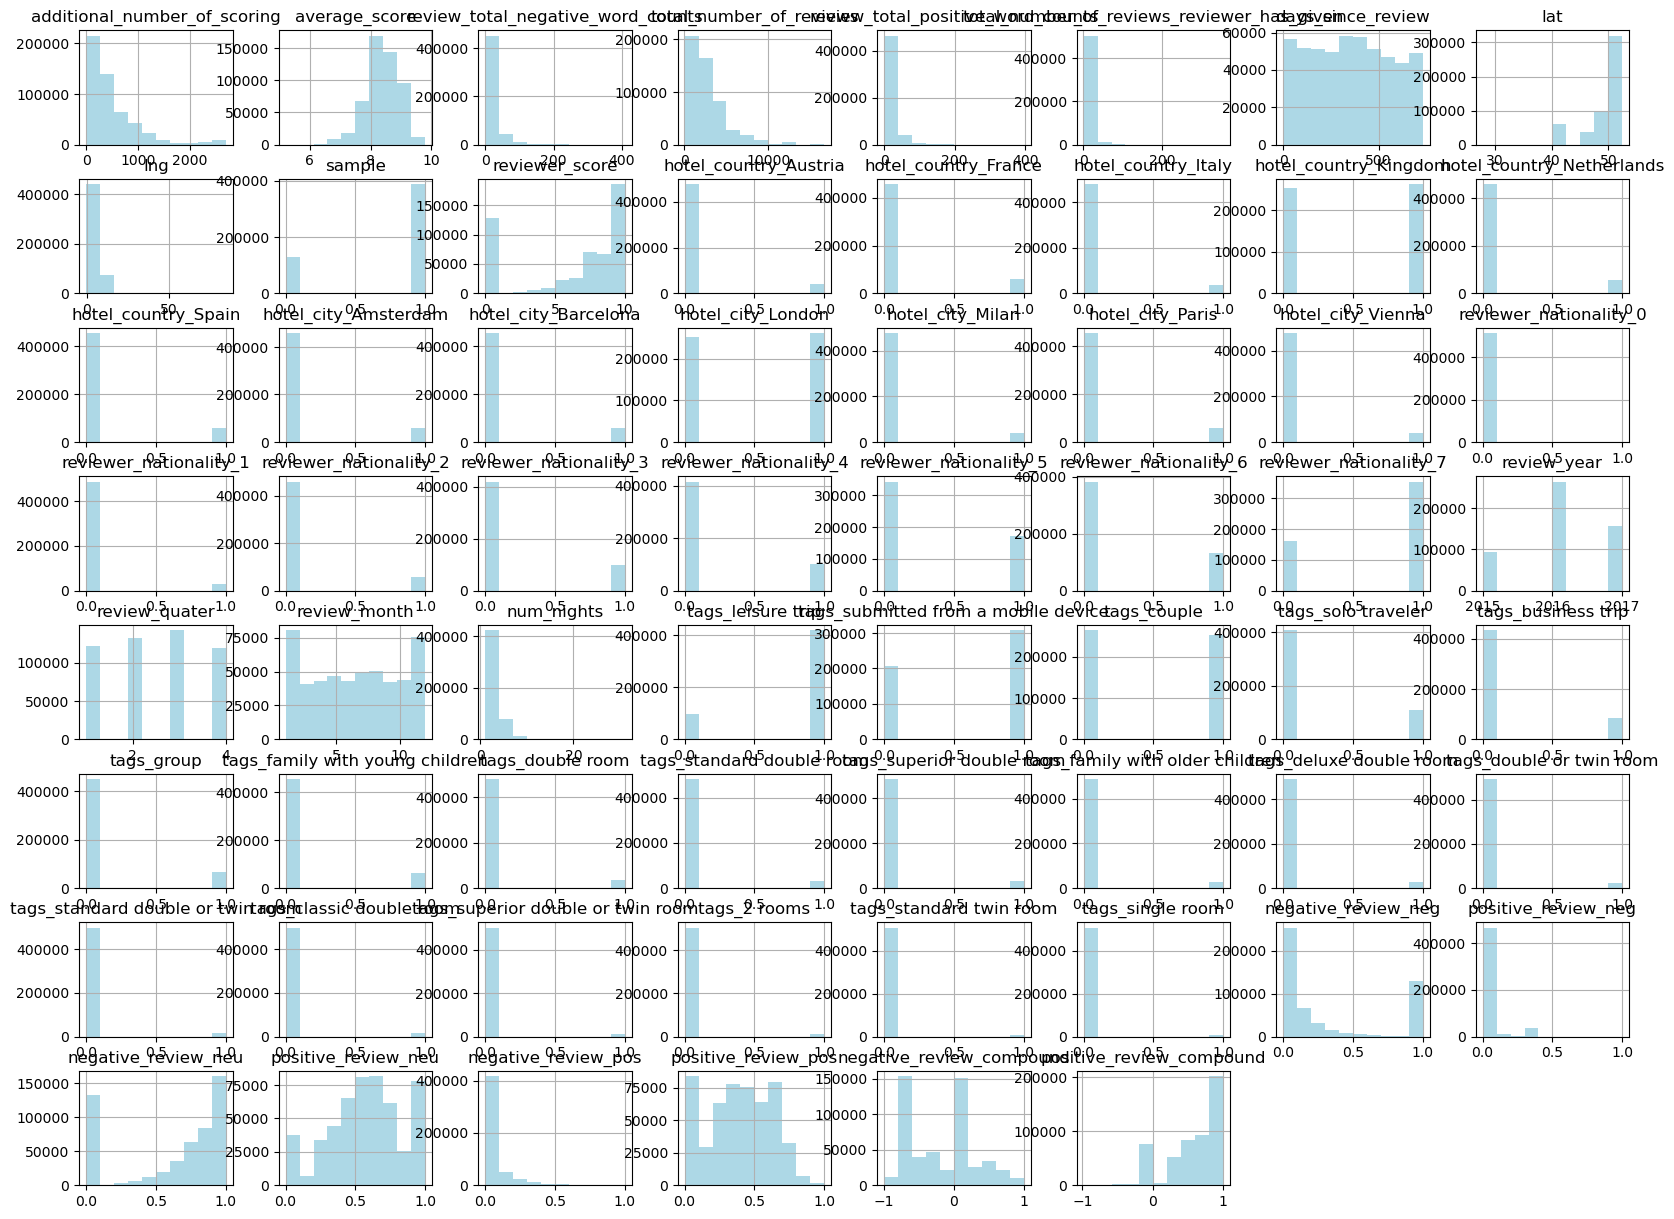

In [196]:
# создадим график - гистограмму по числовым признакам для визуальной оценке распределения признаков
hotels[num_features].hist(figsize=(20, 15), color='lightblue', bins=10);

In [197]:
# нормальизуем числовые признаки

hotels_sc = hotels.copy()

from sklearn.preprocessing import MinMaxScaler

# созданим списо признаков, которые будем нормализовывать
selected_features = ['review_total_negative_word_counts', 
           'review_total_positive_word_counts', 
           'total_number_of_reviews_reviewer_has_given', 
           'additional_number_of_scoring', 
                     'days_since_review', 'num_nights']

# инициализируем нормализатор MinMaxScaler
mm_scaler =  MinMaxScaler()

# вычисляем среднее и стандартное отклонение 
mm_scaler.fit(hotels_sc[selected_features])

# применяем стандартизацию ко всем выбранным признакам в df
hotels_sc[selected_features] = mm_scaler.transform(hotels_sc[selected_features])

In [198]:
hotels = hotels_sc.copy()

In [199]:

# функция для вывода признаков с высокой кореляцией
def get_high_correlation(df, threshold=0.7):
    corr = df.corr().abs()
   # high_corr = (corr[(corr > threshold) & (corr != 1)]
    high_corr = (corr[(corr > threshold)]
                      .stack()
                      .reset_index()
                      .rename(columns={0: 'correlation', 'level_0': 'feature_1', 'level_1': 'feature_2'}))
    high_corr = high_corr[high_corr['feature_1'] != high_corr['feature_2']].sort_values(by='correlation', ascending=False)
                      
    return high_corr

In [200]:
high_corr = get_high_correlation(hotels)
display(high_corr)

/tmp/ipykernel_32/2882169375.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr().abs()


,feature_1,feature_2,correlation
30,hotel_country_Netherlands,hotel_city_Amsterdam,1.000000
28,hotel_country_Kingdom,hotel_city_London,1.000000
46,hotel_city_Vienna,hotel_country_Austria,1.000000
43,hotel_city_Paris,hotel_country_France,1.000000
41,hotel_city_Milan,hotel_country_Italy,1.000000
39,hotel_city_London,hotel_country_Kingdom,1.000000
37,hotel_city_Barcelona,hotel_country_Spain,1.000000
34,hotel_city_Amsterdam,hotel_country_Netherlands,1.000000
33,hotel_country_Spain,hotel_city_Barcelona,1.000000
22,hotel_country_Austria,hotel_city_Vienna,1.000000


In [201]:
# удалим признаки с высокой корреляцие (> 0,9)
# очевидно, что страна-город корр = 1
hotels = hotels.drop(columns=['review_quater',
                            'negative_review_neu',
                           'positive_review_neu',
                           'review_year',
                            'tags_business trip',
                            'total_number_of_reviews'
                            'hotel_country_Spain',
                            'hotel_country_Austria',
                            'hotel_country_France',
                            'hotel_country_Italy',
                            'hotel_country_Kingdom',
                            'hotel_country_Netherlands',
                                   
                                    ], axis=1)

In [203]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  float64       
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  float64       
 8   total_number_of_reviews                     515738 non-null  int64        

In [209]:
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)
hotels.drop('review_date', axis = 1, inplace=True)

<Axes: >

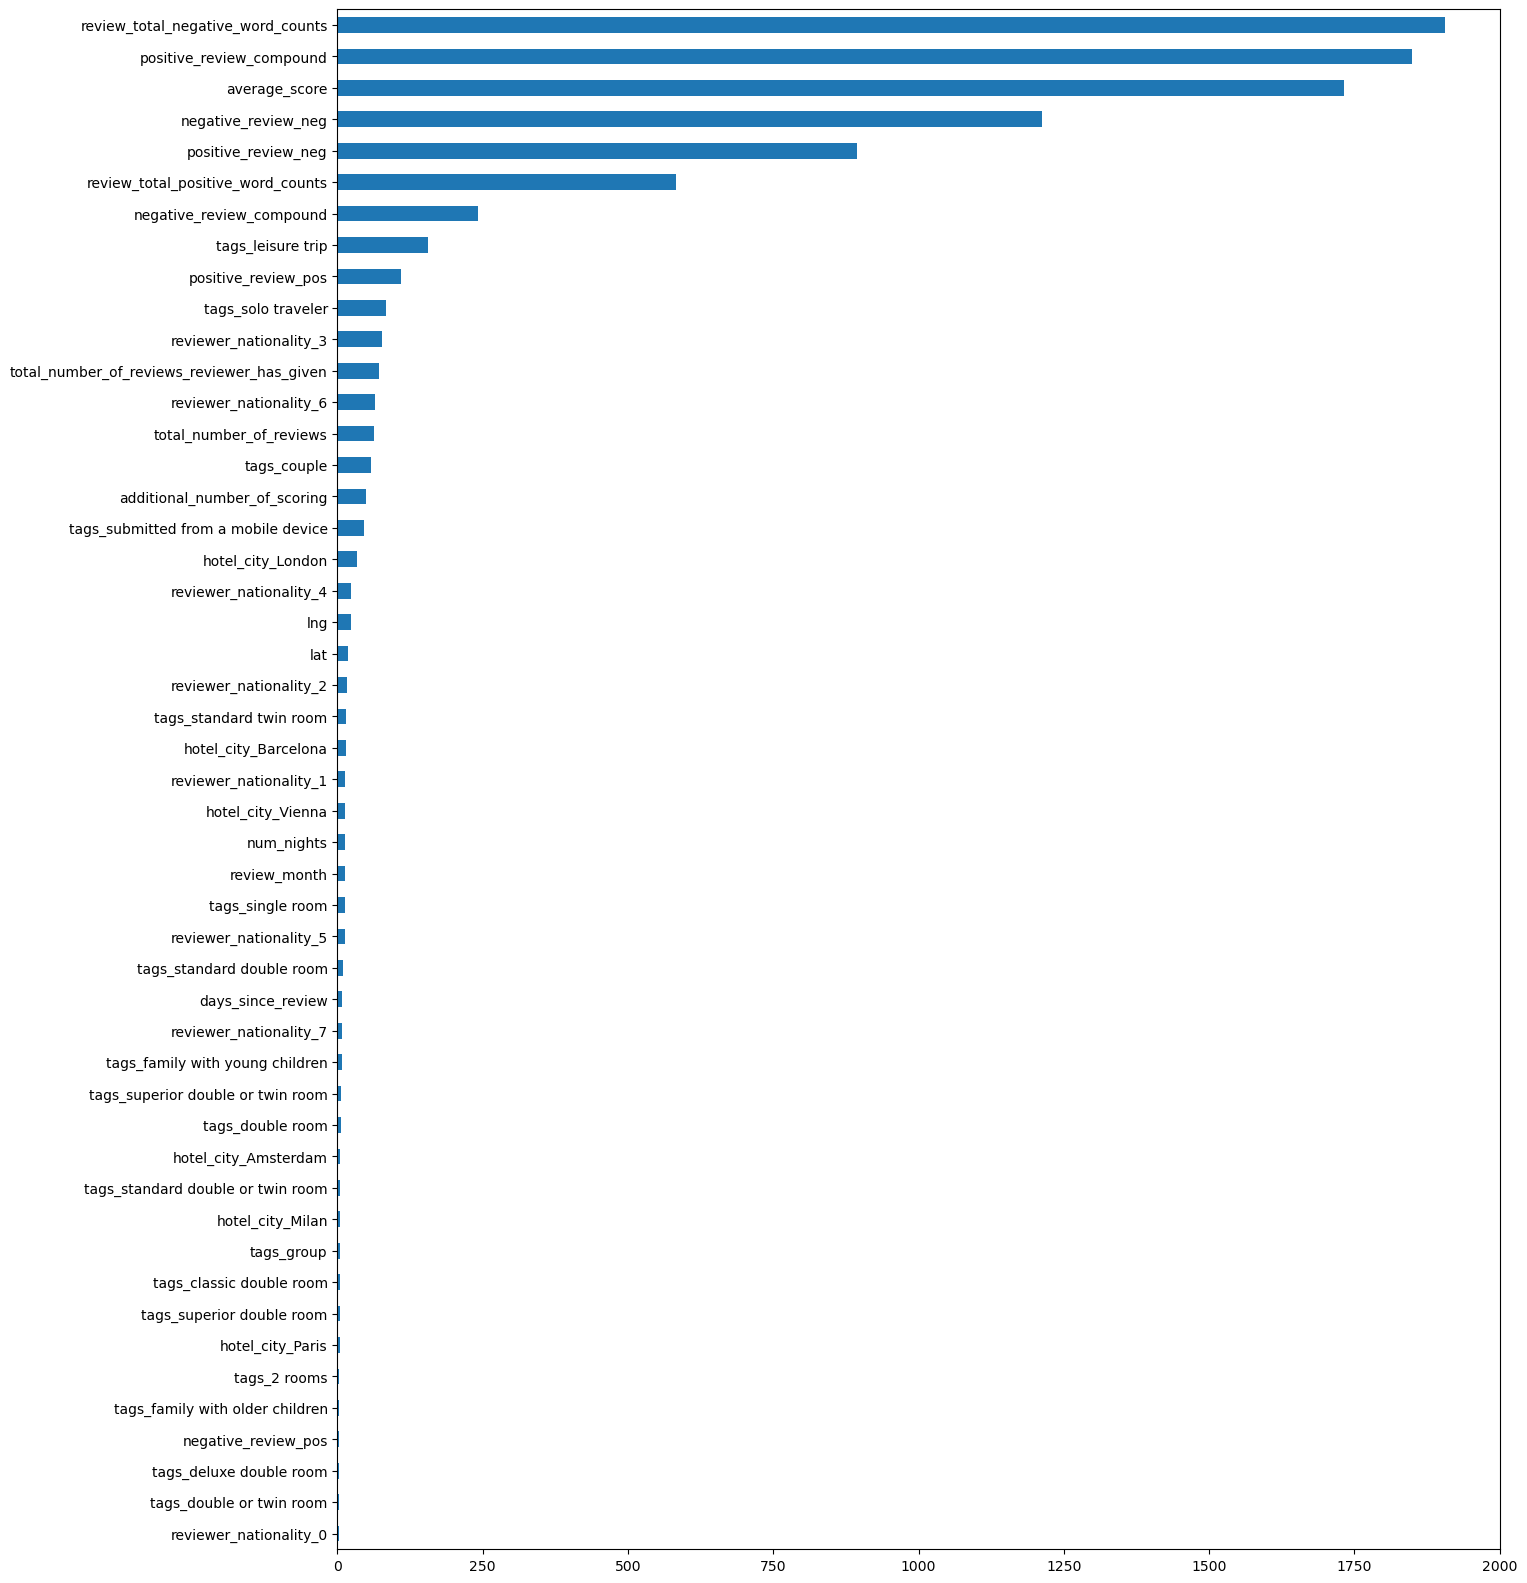

In [210]:
# оценим  значимость признаков
from sklearn.feature_selection import f_classif

y = hotels.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = hotels.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
feat_importances = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
feat_importances.sort_values(inplace = True)



fig5, ax5 = plt.subplots(figsize=(15, 20))
feat_importances.plot(kind = 'barh')

In [211]:
len(feat_importances)

49

In [212]:
# посмотрим наименее значимые и удалим их
lst_for_drop = feat_importances.nsmallest(25).index.to_list()
hotels.drop(lst_for_drop, axis = 1, inplace=True)
hotels.info() # оставили 24 наиболее значимых признаков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  float64
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  float64
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  float64
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [213]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1) # удаляем все лишнее

In [214]:
# Загружаем инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [215]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 25), (386803, 25), (386803, 24), (309442, 24), (77361, 24))

In [217]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [218]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
#model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
model = RandomForestRegressor(n_estimators=100,random_state=42)

In [219]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [220]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12575132190201535


Получили метрику MAPE: 0.12575132190201535

In [222]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [223]:
predict_submission = model.predict(test_data)

In [224]:
predict_submission

array([8.683, 7.752, 8.874, ..., 8.421, 9.651, 7.393])

In [225]:
list(sample_submission)

['reviewer_score', 'id']

In [227]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.683,488440
1,7.752,274649
2,8.874,374688
3,9.766,404352
4,9.701,451596
5,9.241,302161
6,7.780,317079
7,7.523,13963
8,8.498,159785
9,7.553,195089


In [ ]:
Выводы: про корреляцю
    нормализацию, отпбор значимых признаков
    выбросы